In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import h5py
import matplotlib.pyplot as plt
'''import inflect
c2h.stringify = inflect.engine()'''
from tqdm import tqdm
from collections import Counter
import csv_to_hdf5 as c2h
import obspy
import math

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
creepmeter_metadata = pd.read_excel('../../Data/Creepmeter_list.xlsx')
creepmeter_metadata

,Network,Creepmeter_full_name,Creepmeter_abbrv,Latitude,Longitude,Length,Depth,Obliquity,Sensor Type,Rod type,...,Regular sampling mins,Daily,Manual,Temp,orthogonal,voltage,IR,ortho V,To Pick,Column1
0,EAF,Balikburnu,BAL1,37.9903,38.1990,5 m,NaN,30,NaN,NaN,...,Yes,No,No,Yes,No,No,No,No,Yes,NaN
1,CSAF,Bitterwater,BIT1,36.3980,-120.9820,18 m,cm,45,USGS standard,rod,...,No,No,Yes,No,No,No,No,No,NaN,NaN
2,PARK,Highway 46,C461,35.7240,-120.2820,NaN,NaN,30,Bilham #1,Invar,...,Yes,No,No,No,No,No,No,No,No,
3,PARK,Highway 46,C462,35.7240,-120.2820,NaN,NaN,30,LVDT,NaN,...,Yes,No,No,No,No,No,No,No,No,NaN
4,UTA,Canyonlands,CAN1,38.0198,-110.0374,7.5 m,NaN,45,NaN,NaN,...,Yes,No,No,Yes,No,No,No,No,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,HOL,San Juan Bautista #3,XSJ3,36.8360,-121.5210,20 m,NaN,30,USGS standard,NaN,...,Yes,Yes,Yes,No,No,No,No,No,No,NaN
92,PARK,Taylor Ranch,XTA1,35.8900,-120.4270,30 m,1 m,30,USGS standard,wire,...,Yes,Yes,Yes,No,No,No,No,No,No,NaN
93,PARK,Varian,XVA1,35.9220,-120.4620,30 m,1 m,30,USGS standard,wire,...,Yes,Yes,Yes,No,No,No,No,No,No,NaN
94,EAF,Yazica East,YZE1,38.1791,38.7526,20 m,NaN,30,NaN,NaN,...,Yes,No,No,Yes,No,No,No,No,Yes,NaN


In [3]:
# Example usage
directory = '../../Data/DATA_tidied/CSV/'  # Replace with your actual directory path
files = c2h.list_files_in_directory(directory)
print(files)
try:
    Creepmeter_dataframe = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation.csv',index_col=0)
except FileNotFoundError:
    Creepmeter_dataframe = pd.DataFrame()

print(Creepmeter_dataframe)
Creepmeter_dataframe_SAC = pd.DataFrame()

['xmbc.csv', 'cha1.csv', 'crr1.csv', 'xsh1.csv', 'cfw1.csv', 'wkr1.csv', 'FCR1.csv', '.DS_Store', 'bal1.csv', 'yze1.csv', 'has1.csv', 'pas1.csv', 'orm1.csv', 'ham1.csv', 'c462.csv', 'yzw1.csv', 'tas1.csv', 'hat1.csv', 'du30.csv', 'c461.csv', 'gok1.csv', 'ctm1.csv', 'kir1.csv', 'pet1.csv', 'xmd1.csv', 'xsc1.csv', 'can1.csv', 'inw1.csv', 'esz1.csv', 'chp1.csv', 'xmr1.csv', 'gs.csv', 'gd.csv', 'sjn1.csv', 'che1.csv', 'tep1.csv', 'coz1.csv', 'isw1.csv', 'kar1.csv', 'xgh1.csv', 'r7.csv', 'ra.csv', 'xpk1.csv', 'gb.csv', 'pan1.csv', 'rb.csv', 'xpk2.csv', 'xrsw.csv', 'xsj3.csv', 'goz1.csv', 'xva1.csv', 'xsj2.csv', 'xta1.csv', 'cpp1.csv', 'wsz1.csv', 'cwn1.csv', 'xmm1.csv', 'xhr3.csv', 'sel1.csv', 'cwc3.csv', 'xhsw.csv', 'xhr2.csv', 'siv1.csv', 'cer1.csv', 'tabc.csv', 'x461.csv', 'xhr1.csv']
   Network Creepmeter_full_name Creepmeter_abbrv File_code  \
0      EAF           Balikburnu             BAL1      BAL1   
1     PARK           Highway 46             C461      C461   
2     PARK          

In [4]:
del files[7]
print(files)


['xmbc.csv', 'cha1.csv', 'crr1.csv', 'xsh1.csv', 'cfw1.csv', 'wkr1.csv', 'FCR1.csv', 'bal1.csv', 'yze1.csv', 'has1.csv', 'pas1.csv', 'orm1.csv', 'ham1.csv', 'c462.csv', 'yzw1.csv', 'tas1.csv', 'hat1.csv', 'du30.csv', 'c461.csv', 'gok1.csv', 'ctm1.csv', 'kir1.csv', 'pet1.csv', 'xmd1.csv', 'xsc1.csv', 'can1.csv', 'inw1.csv', 'esz1.csv', 'chp1.csv', 'xmr1.csv', 'gs.csv', 'gd.csv', 'sjn1.csv', 'che1.csv', 'tep1.csv', 'coz1.csv', 'isw1.csv', 'kar1.csv', 'xgh1.csv', 'r7.csv', 'ra.csv', 'xpk1.csv', 'gb.csv', 'pan1.csv', 'rb.csv', 'xpk2.csv', 'xrsw.csv', 'xsj3.csv', 'goz1.csv', 'xva1.csv', 'xsj2.csv', 'xta1.csv', 'cpp1.csv', 'wsz1.csv', 'cwn1.csv', 'xmm1.csv', 'xhr3.csv', 'sel1.csv', 'cwc3.csv', 'xhsw.csv', 'xhr2.csv', 'siv1.csv', 'cer1.csv', 'tabc.csv', 'x461.csv', 'xhr1.csv']


In [7]:
files = ['du30.csv']

In [8]:
files.sort()
diff_all = []
count = 0
for file in tqdm(files):
    data = pd.read_csv(directory + file,index_col=0)
    try:
        #print(data['Time'].head(10))
        data['Time'] = pd.to_datetime(data['Time'])
    except KeyError:
        #print(data['Date'].head(10))
        data['Time'] = pd.to_datetime(data['Date'])
    tm_diff = np.diff(data['Time'])/ np.timedelta64(1, 'm')
    negatives = np.any(tm_diff<0)
    if negatives == True:
        where_neg = np.where(tm_diff<0)[0]
        count+=1
        print(where_neg)
        for i in range(len(where_neg)):
            print(data.loc[where_neg[i]-10:where_neg[i]+10])
        print(file, 'negatives!!')
    diff_all.extend(np.unique(tm_diff))
print(count)
print(files)

100%|██████████| 1/1 [00:03<00:00,  3.53s/it]

0
['du30.csv']


In [14]:
DU30 has 4 sampling frequencies

SyntaxError: invalid syntax (2467516399.py, line 1)

DU30
../../Data/DATA_tidied/HDF5/DU30.h5
                        Date     Slip                Time   tm_diff
0        2004-04-16 21:50:00 -20.5100 2004-04-16 21:50:00      10.0
1        2004-04-16 22:00:00 -20.5120 2004-04-16 22:00:00      10.0
2        2004-04-16 22:10:00 -20.5120 2004-04-16 22:10:00      10.0
3        2004-04-16 22:20:00 -20.5120 2004-04-16 22:20:00      10.0
4        2004-04-16 22:30:00 -20.5120 2004-04-16 22:30:00      10.0
...                      ...      ...                 ...       ...
3478235  2024-02-02 20:25:00   8.5805 2024-02-02 20:25:00       1.0
3478236  2024-02-02 20:26:00   8.5805 2024-02-02 20:26:00       1.0
3478237  2024-02-02 20:27:00   8.5805 2024-02-02 20:27:00       1.0
3478238  2024-02-02 20:28:00   8.5802 2024-02-02 20:28:00       1.0
3478239  2024-02-02 20:29:00   8.5802 2024-02-02 20:29:00  123456.0

[3478240 rows x 4 columns]


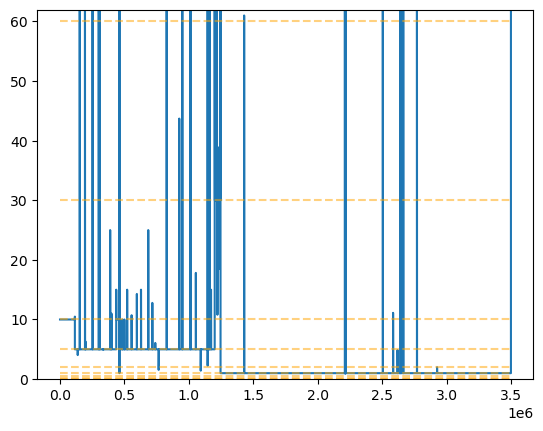

Top 4 modes and their frequencies: [(1.0, 2252831), (5.0, 1059485), (10.0, 140076), (30.0, 44564)]
[1.0, 5.0, 10.0]
[115225 115227 460833]
[ 320755  320757 1117248]
[ 320755 1117248]
                       Date      Slip                Time     tm_diff
0       2004-04-16 21:50:00 -20.51000 2004-04-16 21:50:00   10.000000
1       2004-04-16 22:00:00 -20.51200 2004-04-16 22:00:00   10.000000
2       2004-04-16 22:10:00 -20.51200 2004-04-16 22:10:00   10.000000
3       2004-04-16 22:20:00 -20.51200 2004-04-16 22:20:00   10.000000
4       2004-04-16 22:30:00 -20.51200 2004-04-16 22:30:00   10.000000
...                     ...       ...                 ...         ...
911715  2019-09-10 06:45:04   5.52831 2019-09-10 06:45:04   30.000000
911716  2019-09-10 07:15:04   5.52541 2019-09-10 07:15:04   30.000000
911717  2019-09-10 07:45:04   5.52831 2019-09-10 07:45:04   30.000000
911718  2019-09-10 08:15:04   5.52831 2019-09-10 08:15:04   30.000000
911719  2019-09-10 08:45:04   5.52831 2019-09-1

ValueError: Unable to create group (name already exists)

In [13]:
import importlib
importlib.reload(c2h)
try:
    del creeping_A
except NameError:
    dummy=10

try:
    del creeping_B
except NameError:
    dummy=10
try:
    del creeping_C
except NameError:
    dummy=10
sac_vs_hdf5='hdf5'
Creepmeter_dataframe_SAC = pd.DataFrame()
for file in files:
    # Extract the first 4 letters in uppercase
    abbreviation = file[:4].upper()
    print(abbreviation)
    try:
        fn = '{k}'.format(k=abbreviation)
        prefix = 'Slip'
        index_CM = np.where(creepmeter_metadata['Creepmeter_abbrv']==abbreviation)[0][0]
        full_name = creepmeter_metadata['Creepmeter_full_name'].iloc[index_CM]
        latitude = creepmeter_metadata['Latitude'].iloc[index_CM]
        longitude = creepmeter_metadata['Longitude'].iloc[index_CM]
        depth = creepmeter_metadata['Depth'].iloc[index_CM]
        length = creepmeter_metadata['Length'].iloc[index_CM]
        obliquity = creepmeter_metadata['Obliquity'].iloc[index_CM]
        network = creepmeter_metadata['Network'].iloc[index_CM]
        full_name = creepmeter_metadata['Creepmeter_full_name'].iloc[index_CM]
    
    
        hdf5_path = '../../Data/DATA_tidied/HDF5/' + fn +'.h5'
        sac_path = '../../Data/DATA_tidied/SAC/' + fn +'.SAC'

        if sac_vs_hdf5 == 'hdf5':
            path = hdf5_path
        elif sac_vs_hdf5 == 'sac':
            path=sac_path
        print(path)
        if not os.path.isfile(path):
            data = pd.read_csv(directory + file,index_col=0)
            try:
                data['Time'] = pd.to_datetime(data['Time'])
            except KeyError:
                data['Time'] = pd.to_datetime(data['Date'])

            tm_diff = np.diff(data['Time'])/ np.timedelta64(1, 'm')
            tm_diff = np.append(tm_diff,123456)
            #tm_diff = c2h.round_to_nearest_half(tm_diff)
            data['tm_diff'] = tm_diff
            data.dropna(inplace=True)
            #data['tm_diff'] = c2h.round_to_nearest_half(data['tm_diff'])
            data.reset_index(inplace=True,drop=True)
            print(data)

            boolarr = tm_diff <1/60
            same_time = tm_diff[boolarr] 

            if len(same_time) >0:
                datapoint_to_drop = np.where(tm_diff <1/60)[0][0]
                data.drop(datapoint_to_drop,inplace=True)
                data.reset_index(inplace=True)
                data.drop(['index'],axis=1,inplace=True)
                boolarr_diff = tm_diff >= 1/60
                tm_diff = tm_diff[boolarr_diff]
            data.drop(data.loc[data.Time.isnull()].index,inplace=True)
            data.reset_index(inplace=True,drop=True) 
            data['Slip'] = data['Slip'].astype(float)

            plt.figure()
            ax = plt.subplot(1,1,1)
            plt.plot(tm_diff)
            plt.ylim(0,62)
            plt.hlines([1/60,1/6,1/2,1,2,5,10,30,60],xmin=0,xmax=len(tm_diff),colors='orange',linestyles='--',alpha=0.5)
            plt.show()

            allowed_modes = [1/60,1/6,1/2,1,2,5,10,30,60]
            top_4_modes = c2h.find_top_modes(tm_diff, 4,allowed_modes)
            print("Top 4 modes and their frequencies:", top_4_modes)
            no_mode = input('how many sampling frequencies?')
            reversal = input('does the smaple rate revert to an earlier one? (y/n)')
            periods = []
            for q in range(int(no_mode)):
                periods.append(top_4_modes[q][0])
            print(periods)



            if len(periods)==3:
                a = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                b = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
                c = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[2])))
                d = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[0])))
                e = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[2])))
                f = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[1])))

                indices = sorted([a,b,c,d,e,f])
                unique_ind = np.unique(indices)
                print(unique_ind)
                creeping_A = data.iloc[:unique_ind[1]]      # From start to 'a' (exclusive)
                the_rest = data.iloc[unique_ind[1]:]

                if reversal == 'y':
                    the_rest.reset_index(inplace=True,drop=True)
                    a = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                    b = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
                    c = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[2])))
                    d = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[0])))
                    e = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[2])))
                    f = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[1])))
                    indices = sorted([a,b,c,d,e,f])
                    unique_ind = np.unique(indices)

                    print(unique_ind)
                    if abbreviation == 'CHE1':
                        a = 87593
                        b = 617992
                    
                    indices = np.unique([a,b])
                    print(indices)

                    creeping_B = the_rest.iloc[:indices[0]]
                    creeping_D = the_rest.iloc[indices[0]:indices[1]]
                    creeping_C = the_rest.iloc[indices[1]:]
                    creeping_A = pd.concat([creeping_A,creeping_D],ignore_index=True)
                    creeping_B.reset_index(inplace=True,drop=True)
                    creeping_C.reset_index(inplace=True,drop=True)
                    del creeping_D




                else:
                    creeping_B = data.iloc[unique_ind[1]:unique_ind[2]]    # From 'a' (inclusive) to 'b' (exclusive)
                    creeping_C = data.iloc[unique_ind[2]:]     # From 'b' (inclusive) to 'c' (exclusive)
                    
                    creeping_A.reset_index(inplace=True,drop=True)
                    creeping_B.reset_index(inplace=True,drop=True)
                    creeping_C.reset_index(inplace=True,drop=True)
                
                print(creeping_A)
                print(creeping_B)
                print(creeping_C)


            elif len(periods) ==2:
                a = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                b = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))

                indices = sorted([a,b])
                unique_ind = np.unique(indices)
                creeping_A = data.iloc[:unique_ind[1]]
                the_rest = data.iloc[unique_ind[1]:]
                
                if reversal == 'y':
                    the_rest.reset_index(inplace=True,drop=True)
                    a = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                    b = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
                    print(a,b)
                    if abbreviation == 'R7' or abbreviation == 'RB':
                        a = 17179
                    indices = np.unique([a,b])
                    print(indices)

                    creeping_B = the_rest.iloc[indices[0]:indices[1]]
                    creeping_C  = the_rest.iloc[indices[1]:]
                    
                    creeping_A = pd.concat([creeping_A,creeping_C],ignore_index=True)
                    creeping_B.reset_index(inplace=True,drop=True)
                    del creeping_C

                else:
                    creeping_B = data.iloc[unique_ind[1]:]
                    creeping_A.reset_index(inplace=True,drop=True)
                    creeping_B.reset_index(inplace=True,drop=True)

                print(creeping_A)
                print(creeping_B)

            elif len(periods) == 1:
                creeping_A = data.iloc[:]
                print(creeping_A)
            
            
            Number_of_splits = []
            Sampling_rates_variable = []
            try:
                sampling_A = c2h.find_top_modes(creeping_A['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_A)
                Number_of_splits.append('A')
            except (IndexError, NameError, KeyError):
                sampling_A = 0

            try:
                sampling_B = c2h.find_top_modes(creeping_B['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_B)
                Number_of_splits.append('B')
            except (IndexError, NameError, KeyError):
                sampling_B = 0

            try:
                sampling_C = c2h.find_top_modes(creeping_C['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_C)
                Number_of_splits.append('C')
            except (IndexError, NameError, KeyError):
                sampling_C = 0

            print(Sampling_rates_variable,Number_of_splits)

            if sac_vs_hdf5 == 'sac':
                for i in range(len(Number_of_splits)):
                    print('interpolating creeping_{k}'.format(k=Number_of_splits[i]))
                    upsampled = eval('creeping_{k}'.format(k=Number_of_splits[i]))
                    val1_okay = math.isnan(upsampled.Slip.iloc[0])
                    if val1_okay == True:
                        upsampled.reset_index(inplace=True)
                        upsampled.drop([0],axis=0,inplace=True)
                    tr = obspy.Trace(np.array(upsampled.Slip))
                    st = obspy.Stream(tr)
                    st[0].stats.network = network
                    st[0].stats.station = abbreviation
                    st[0].stats.location = '00'
                    st[0].stats.channel = 'slip'
                    st[0].stats.starttime = pd.to_datetime(upsampled.Time.iloc[0])
                    st[0].stats.delta = 60*Sampling_rates_variable[i]
                    #st[0].plot()
                    instrument = pd.DataFrame({'Network':[st[0].stats.network],'Creepmeter_full_name':['{k}'.format(k=full_name)],
                                            'Creepmeter_abbrv':['{k}'.format(k=abbreviation)],'File_code':['{p}_{q}'.format(p=abbreviation,q=i)],
                                            'Start Time':[st[0].stats.starttime],'End Time':[st[0].stats.endtime],
                                            'Sampling rate, Hz':[st[0].stats.sampling_rate],'Sampling rate, mins':(1/st[0].stats.sampling_rate)/60,
                                            'Latitude':[latitude],'Longitude':[longitude]})
                    
                    Creepmeter_dataframe_SAC = pd.concat([Creepmeter_dataframe_SAC,instrument],ignore_index=True)
                    Creepmeter_dataframe_SAC.drop_duplicates(subset='File_code',inplace=True)
                    Creepmeter_dataframe_SAC.reset_index(inplace=True,drop=True)
                    
                    Creepmeter_dataframe_SAC.to_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes.csv')
                    path = '../../Data/DATA_tidied/SAC/'
                    st.write(path +'{p}_{q}.SAC'.format(p=abbreviation,q=i),format='SAC')
                    st[0].plot();
                print(Creepmeter_dataframe_SAC)
                try:
                    del creeping_A
                except NameError:
                    dummy=10

                try:
                    del creeping_B
                except NameError:
                    dummy=10
                try:
                    del creeping_C
                except NameError:
                    dummy=10
            
            elif sac_vs_hdf5 =='hdf5':
                with h5py.File(path, 'w') as f:
                    f.attrs['author'] = 'Daniel B. Gittins'
                    f.attrs['network'] = network
                    f.attrs['latitude'] = latitude
                    f.attrs['longitude'] = longitude
                    f.attrs['depth'] = depth
                    f.attrs['length'] = length
                    f.attrs['obliquity'] = obliquity
                    # Create a group to store both waves together
                    for i in range(len(Number_of_splits)):
                        smpl_rate = Sampling_rates_variable[i]
                        group_name = fn+'_{k}mins'.format(k=smpl_rate)
                        time_data = eval('creeping_{k}.Time'.format(k=Number_of_splits[i]))
                        # Assuming 'data['Time']' is your pandas Series of datetime objects
                        datetime_strings = time_data.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()

                        dependent_data = eval('creeping_{k}.Slip'.format(k=Number_of_splits[i])).tolist()
                        group = f.create_group(group_name)
                        # Create datasets for time and dependent variable in the group
                        group.create_dataset('Time_{p}_{k}mins'.format(p=abbreviation,k=smpl_rate), data=datetime_strings)
                        group.create_dataset('Slip_{p}_{k}mins'.format(p=abbreviation,k=smpl_rate), data=dependent_data)
                    
                        
                        # Store metadata about the dependent variable
                        if Sampling_rates_variable[i] >=1:
                            description = f"Slip for {abbreviation} at {smpl_rate} minute sampling"
                        else:
                            description = f"Slip for {abbreviation} at {smpl_rate*60} second sampling"
                        group.attrs['description'] = description

                        
                        # Optional: Store additional metadata (e.g., units, sampling rate)
                        starttime = eval('creeping_{k}.Time.iloc[0]'.format(k=Number_of_splits[i]))
                        endtime = eval('creeping_{k}.Time.iloc[-1]'.format(k=Number_of_splits[i]))
                        group.attrs['sampling_rate'] = Sampling_rates_variable[i]  # Example: 100 Hz sampling rate (10 ms interval)
                        group.attrs['time_units'] = 'minutes'     # Time units
                        group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
                        group.attrs['channel'] = 'slip'
                        group.attrs['starttime'] = starttime.strftime('%Y-%m-%d %H:%M:%S')
                        group.attrs['delta'] = 60*Sampling_rates_variable[i]
                        instrument = pd.DataFrame({'Network':[network],'Creepmeter_full_name':[full_name],'Creepmeter_abbrv':[abbreviation],'File_code':[fn],
                                                'Start Time':[starttime],'End Time':[endtime],'Sampling rate, mins':[smpl_rate],
                                                'Latitude':[latitude],'Longitude':[longitude],'Description':[description],'Depth':[depth],'Length':[length],
                                                'Obliquity':[obliquity],'group_name':group_name})
                        Creepmeter_dataframe = pd.concat([Creepmeter_dataframe,instrument],ignore_index=True)
                    try:
                        del creeping_A
                    except NameError:
                        dummy=10

                    try:
                        del creeping_B
                    except NameError:
                        dummy=10
                    try:
                        del creeping_C
                    except NameError:
                        dummy=10
                print('HDF5 structure')
                c2h.print_hdf5_structure('../../Data/DATA_tidied/HDF5/' + fn +'.h5')
                Creepmeter_dataframe.drop_duplicates()
                Creepmeter_dataframe.reset_index(inplace=True,drop=True)
                Creepmeter_dataframe.to_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation.csv')
                print('Creepmeter_meta_data')
                print(Creepmeter_dataframe)
    except IndexError:
        dummy=10




Adding Temperature

In [16]:
Temp = pd.read_csv('../../Data/DATA_tidied/CSV/Temperature/Cherry_Temp.csv',index_col=0)

In [17]:
Temp['Date'] = pd.to_datetime(Temp['Date'])

In [18]:
abbreviation = 'CHE1'

In [20]:
time_data = Temp['Date']
datetime_strings = time_data.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
dependent_data = Temp['degC'].tolist()
hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
with h5py.File(hdf5_path, 'a') as f:
    #del f['Temperature']
    group = f.create_group('Temperature')
    # Create datasets for time and dependent variable in the group
    group.create_dataset('Time_{p}'.format(p=abbreviation), data=datetime_strings)
    group.create_dataset('Temperature_{p}'.format(p=abbreviation), data=dependent_data)
    group.attrs['Units'] = 'Celsius'
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

HDF5 structure
Group: /
Group: /CHE1_0.5mins/
  Dataset: Slip_CHE1_0.5mins, Shape: (591426,), Dtype: float64
  Dataset: Time_CHE1_0.5mins, Shape: (591426,), Dtype: object
Group: /CHE1_1.0mins/
  Dataset: Slip_CHE1_1.0mins, Shape: (587201,), Dtype: float64
  Dataset: Time_CHE1_1.0mins, Shape: (587201,), Dtype: object
Group: /CHE1_5.0mins/
  Dataset: Slip_CHE1_5.0mins, Shape: (87593,), Dtype: float64
  Dataset: Time_CHE1_5.0mins, Shape: (87593,), Dtype: object
Group: /Temperature/
  Dataset: Temperature_CHE1, Shape: (1266220,), Dtype: float64
  Dataset: Time_CHE1, Shape: (1266220,), Dtype: object


Daily

In [ ]:
Daily = pd.read_csv('../../Data/DATA_tidied/CSV/Daily/xva1_day.csv',index_col=0)
Daily

In [284]:
abbreviation = 'XVA1'

In [ ]:
datetime_strings = Daily['Time'].tolist()
dependent_data = Daily['Slip'].tolist()
hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
with h5py.File(hdf5_path, 'a') as f:
    #del f['Daily measurements']
    group = f.create_group('Daily_measurements')
    # Create datasets for time and dependent variable in the group
    group.create_dataset('Time_{p}_daily'.format(p=abbreviation), data=datetime_strings)
    group.create_dataset('Slip_{p}_daily'.format(p=abbreviation), data=dependent_data)
    group.attrs['Units_slip'] =  'millimetres'
    group.attrs['Start date'] = datetime_strings[0]
    group.attrs['End date'] = datetime_strings[-1]
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

Manual

In [ ]:
Manual = pd.read_csv('../../Data/DATA_tidied/CSV/Manual/bit1_man.csv',index_col=0)
Manual

In [533]:
abbreviation = 'BIT1'

In [ ]:
datetime_strings = Manual['Time'].tolist()
dependent_data = Manual['Slip'].tolist()
hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
with h5py.File(hdf5_path, 'a') as f:
    del f['Manual_measurements']
    group = f.create_group('Manual_measurements')
    # Create datasets for time and dependent variable in the group
    group.create_dataset('Time_{p}_Manual'.format(p=abbreviation), data=datetime_strings)
    group.create_dataset('Slip_{p}_Manual'.format(p=abbreviation), data=dependent_data)
    group.attrs['Units_slip'] =  'millimetres'
    group.attrs['Start date'] = datetime_strings[0]
    group.attrs['End date'] = datetime_strings[-1]
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

Orthogonal

In [27]:
Ortho = pd.read_csv('../../Data/DATA_tidied/CSV/Orthogonal/FoxCreek_Orthogonal.csv',index_col=0)
Ortho['Date'] = pd.to_datetime(Ortho['Date'])
tm_diff = np.diff(Ortho['Date'])/ np.timedelta64(1, 'm')
Ortho['diff'] = np.append(tm_diff,123456)
Ortho

,Date,Ortho,diff
0,2022-06-06 00:01:00,4.9185,1.0
1,2022-06-06 00:02:00,4.9182,1.0
2,2022-06-06 00:03:00,4.9182,1.0
3,2022-06-06 00:04:00,4.9182,1.0
4,2022-06-06 00:05:00,4.9182,1.0
...,...,...,...
815271,2024-03-03 19:59:00,5.7101,1.0
815272,2024-03-03 20:00:00,5.7101,1.0
815273,2024-03-03 20:01:00,5.7101,1.0
815274,2024-03-03 20:02:00,5.7101,1.0


In [28]:
abbreviation = 'FCR1'

In [29]:
time_data = Ortho['Date']
datetime_strings = time_data.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
dependent_data = Ortho['Ortho'].tolist()
hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
with h5py.File(hdf5_path, 'a') as f:
    del f['Orthogonal']
    group = f.create_group('Orthogonal')
    # Create datasets for time and dependent variable in the group
    group.create_dataset('Time_{p}_Orthogonal'.format(p=abbreviation), data=datetime_strings)
    group.create_dataset('Slip_{p}_Orthogonal'.format(p=abbreviation), data=dependent_data)
    group.attrs['Units_Orthogonal'] =  'millimetres'
    group.attrs['Start date'] = datetime_strings[0]
    group.attrs['End date'] = datetime_strings[-1]
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

HDF5 structure
Group: /
Group: /FCR1_1.0mins/
  Dataset: Slip_FCR1_1.0mins, Shape: (815276,), Dtype: float64
  Dataset: Time_FCR1_1.0mins, Shape: (815276,), Dtype: object
Group: /FXC1_1.0mins/
  Dataset: Slip_FXC1_1.0mins, Shape: (815276,), Dtype: float64
  Dataset: Time_FXC1_1.0mins, Shape: (815276,), Dtype: object
Group: /Orthogonal/
  Dataset: Slip_FCR1_Orthogonal, Shape: (815276,), Dtype: float64
  Dataset: Time_FCR1_Orthogonal, Shape: (815276,), Dtype: object
Group: /Temperature/
  Dataset: Temperature_FCR1, Shape: (815276,), Dtype: float64
  Dataset: Time_FCR1, Shape: (815276,), Dtype: object


In [30]:
with h5py.File(hdf5_path, 'r+') as f:
    f.attrs['length'] = '9.1 m'
    f.attrs['obliquity'] = 30

HDF5 to SAC

Key: CWN1_1.0mins
Data: <HDF5 group "/CWN1_1.0mins" (2 members)>
Slip: [389.44025 389.43839 389.43839 ... 424.91962 424.91962 424.92059]
Time: DatetimeIndex(['2020-09-22 13:52:00', '2020-09-22 13:52:59',
               '2020-09-22 13:54:00', '2020-09-22 13:54:59',
               '2020-09-22 13:56:00', '2020-09-22 13:57:00',
               '2020-09-22 13:57:59', '2020-09-22 13:59:00',
               '2020-09-22 13:59:59', '2020-09-22 14:01:00',
               ...
               '2023-12-15 12:51:00', '2023-12-15 12:51:59',
               '2023-12-15 12:53:00', '2023-12-15 12:54:00',
               '2023-12-15 12:54:59', '2023-12-15 12:56:00',
               '2023-12-15 12:56:59', '2023-12-15 12:58:00',
               '2023-12-15 12:58:59', '2023-12-15 13:00:00'],
              dtype='datetime64[ns]', length=1573217, freq=None)
<Attributes of HDF5 object at 140592647257872>
Key: CWN1_10.0mins
CWN1_10.0mins not a key, if daily or manual do not worry.
Data: <HDF5 group "/CWN1_10.0mins" (2 

Code below is for importing into Igor

In [ ]:
#pragma TextEncoding = "UTF-8"
#pragma rtGlobals=3
#pragma DefaultTab={3,20,4}

// Creates a date/time wave from a date wave stored as text in YYYY-MM-DD format
// and a time wave stored as text in HH:MM:YY format.
// Example:
//      Make/O/T wDateAsText = {"2016-08-15", "2016-08-15"}
//      Make/O/T wTimeAsText = {"19:01:00", "19:01:18"}
//      TextWavesToDateTimeWave(wDateAsText, wTimeAsText, "wDateTime")
//      Edit wDateTime

Function ConvertTextToDateTime(dateTimeAsText)
    String dateTimeAsText       // Assumed in YYYY-MM-DD HH:MM:SS format
    
    Variable dt
    Variable year, month, day
    Variable hour, minute, second

    // Use sscanf to parse the full datetime string
    sscanf dateTimeAsText, "%d-%d-%d %d:%d:%d", year, month, day, hour, minute, second
    
    // Convert the date part to seconds since the epoch
    dt = Date2Secs(year, month, day)
    
    // Calculate the time of day in seconds
    Variable timeOfDay = 3600 * hour + 60 * minute + second
    
    // Add the time of day to the date
    dt += timeOfDay
    
    return dt
End


Function/WAVE TextWavesToDateTimeWave(dateTimeAsTextWave, outputWaveName)
    WAVE/T dateTimeAsTextWave       // Assumed in YYYY-MM-DD HH:MM:SS format
    String outputWaveName

    Variable numPoints = numpnts(dateTimeAsTextWave)
    Make/O/D/N=(numPoints) $outputWaveName
    WAVE wOut = $outputWaveName
    SetScale d, 0, 0, "dat", wOut
   
    Variable i
    for(i=0; i<numPoints; i+=1)
        String dateTimeAsText = dateTimeAsTextWave[i]
        Variable dt = ConvertTextToDateTime(dateTimeAsText)
        wOut[i] = dt   
    endfor 

    return wOut
End